In [12]:
import pandas as pd 
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
data = pd.read_csv('spotify.csv', na_values=['-', ' ', ''])
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   released_year         953 non-null    int64  
 2   in_spotify_playlists  953 non-null    int64  
 3   in_spotify_charts     951 non-null    float64
 4   streams               953 non-null    int64  
 5   in_apple_playlists    953 non-null    int64  
 6   in_apple_charts       951 non-null    float64
 7   bpm                   953 non-null    int64  
 8   mode                  953 non-null    object 
 9   energy                953 non-null    int64  
 10  instrumentalness      953 non-null    int64  
 11  liveness              953 non-null    int64  
 12  speechiness           953 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 96.9+ KB
None


In [14]:
thirdQuantile = data['streams'].quantile(0.75)
data['HighStreams'] = (data['streams'] > thirdQuantile).astype(int)
# data['HighStreams'] = np.where(data['streams'] > thirdQuantile, 1, 0)
print(data['HighStreams'].head())

0    0
1    0
2    0
3    1
4    0
Name: HighStreams, dtype: int32


In [15]:
print(data['in_spotify_charts'].head())
print(data['in_apple_charts'].head())

ps = shapiro(data['in_spotify_charts'].dropna())
print(ps)
ps = shapiro(data['in_apple_charts'].dropna())
print(ps)

sm = data['in_spotify_charts'].median()
data['in_spotify_charts'].fillna(sm, inplace=True)

am = data['in_apple_charts'].median()
data['in_apple_charts'].fillna(am, inplace=True)

0    147.0
1     48.0
2    113.0
3      NaN
4     50.0
Name: in_spotify_charts, dtype: float64
0    263.0
1    126.0
2    207.0
3    207.0
4    133.0
Name: in_apple_charts, dtype: float64
ShapiroResult(statistic=0.665931224822998, pvalue=1.4519175687516224e-39)
ShapiroResult(statistic=0.8839384317398071, pvalue=4.468788251553773e-26)


In [16]:
data.drop(columns=['track_name'], inplace=True)

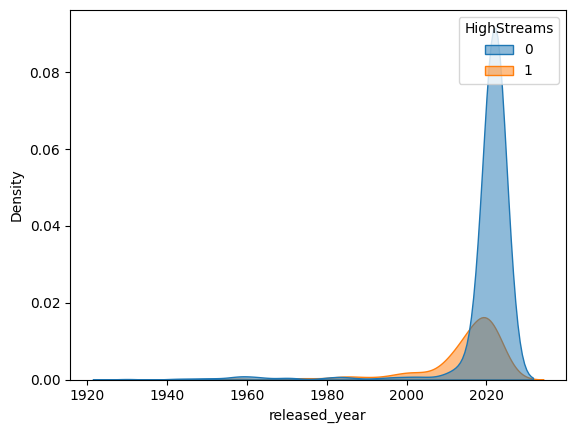

In [18]:
# plt.figure(figsize=(6,4))
# KDE - Kernel Density Estimate
sns.kdeplot(data=data, x='released_year', hue='HighStreams', fill=True, alpha=0.5)
plt.show()
# Most songs are released around 2020 in our dataset
# There is a lot more low stream songs

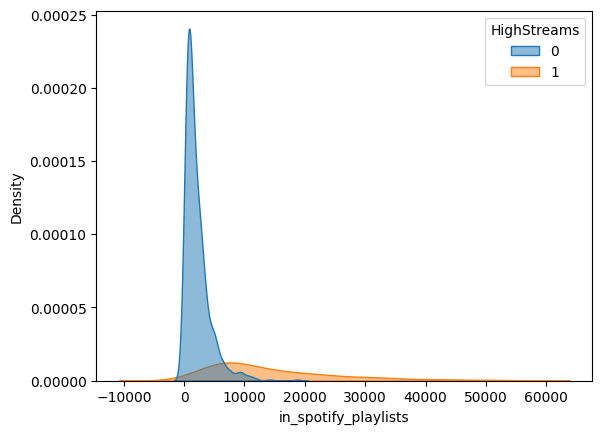

In [20]:
sns.kdeplot(data=data, x='in_spotify_playlists', hue='HighStreams', fill=True, alpha=0.5)
plt.show()

In [21]:
data.drop(columns='bpm', inplace=True)
data.drop(columns='liveness', inplace=True)
data.drop(columns='energy', inplace=True)
data.drop(columns='instrumentalness', inplace=True)
data.drop(columns='speechiness', inplace=True)

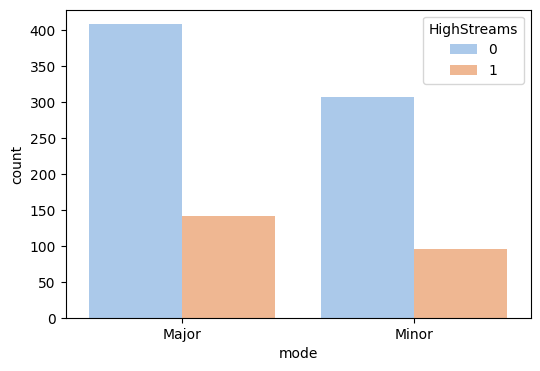

In [ ]:
# If it was the case that in minor and major there is the same proportion of high and low stream songs, we would drop that column too
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='mode', hue='HighStreams', palette='pastel')

plt.show()

In [24]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   released_year         953 non-null    int64  
 1   in_spotify_playlists  953 non-null    int64  
 2   in_spotify_charts     953 non-null    float64
 3   streams               953 non-null    int64  
 4   in_apple_playlists    953 non-null    int64  
 5   in_apple_charts       953 non-null    float64
 6   mode                  953 non-null    object 
 7   HighStreams           953 non-null    int32  
dtypes: float64(2), int32(1), int64(4), object(1)
memory usage: 56.0+ KB
None


In [25]:
numeric_vars = ['released_year', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts']

In [31]:
# Standardization or Normalization? 
# Normalization (min-max scaling) rescales data based on the minimum and maximum values.
# Standardization (z-score scaling) centers the data around the mean and scales by standard deviation.
# When we have a lot of outliers, it's better to use Standardization.

# BITWISE EXAMPLE
# a = pd.Series([True, False, True, False])
# b = pd.Series([False, False, True, True])

# result_or = a | b    # element-wise OR
# result_and = a & b   # element-wise AND

# print(result_or)  
# # 0     True
# # 1    False
# # 2     True
# # 3     True
# # dtype: bool

# OR/AND EXAMPLE
# a = True
# b = False

# if a or b:
#     print("At least one is True")

# if a and b:
#     print("Both are True")

for num_var in numeric_vars:
    q1 = data[num_var].quantile(0.25)
    q3 = data[num_var].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    number_of_outliers = ((data[num_var] < lower) | (data[num_var] > upper)).sum()
    print(number_of_outliers)

151
109
76
78
12
